<a href="https://colab.research.google.com/github/deepralhan26/Pneumonia-Detecter/blob/main/Pneumonia_Detecter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # for linear algebra
import pandas as pd # for data processing
import os # for interacting b/w os and notebook

In [2]:
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns # for plotting
import keras #artificial neural network library
#importing models
from keras.models import Sequential 
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
# For spliiting the data
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2


The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans.

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = get_data('/content/drive/MyDrive/chest_xray/train')
test = get_data('/content/drive/MyDrive/chest_xray/test')
val = get_data('/content/drive/MyDrive/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


Data Visualisation and Pre-Processing

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


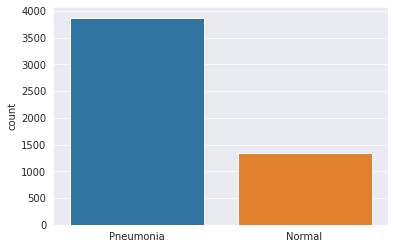

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)   

Text(0.5, 1.0, 'NORMAL')

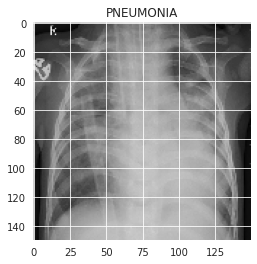

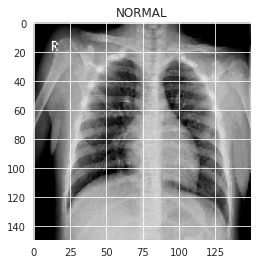

In [6]:
plt.figure(figsize = (4,4))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (4,4))
plt.imshow(train[-1][0], cmap='gray') # to normalise brightness effect
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [8]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255 #normalizing fir faster CNN convergence

In [9]:
x_train = x_train.reshape(x_train.shape[0] ,x_train.shape[1] ,x_train.shape[2] , 1)
x_test = x_test.reshape(x_test.shape[0] ,x_test.shape[1] ,x_test.shape[2] , 1)  
x_val = x_val.reshape(x_val.shape[0] ,x_val.shape[1] ,x_val.shape[2] , 1)

In [10]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 45,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.17,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.13,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [11]:
model = Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [13]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 30s 71ms/step - loss: 0.6365 - accuracy: 0.8081 - val_loss: 20.1750 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 11s 66ms/step - loss: 0.2978 - accuracy: 0.8841 - val_loss: 27.7571 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 11s 65ms/step - loss: 0.2440 - accuracy: 0.9100 - val_loss: 15.3462 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
163/163 [==============================] - 11s 65ms/step - loss: 0.1599 - accuracy: 0.9421 - val_loss: 11.7492 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - 11s 65ms/step - loss: 0.1389 - accuracy: 0.9504 - val_loss: 0.7402 - val_accuracy: 0.6875
Epoch 6/12
163/163 [==============================] - 11s 65ms/step - loss: 0.1271 - accuracy: 0.9493 - val_loss: 36.0046 - val_accuracy: 0.5000
Epoch 7/12
163/163 [==============================

In [14]:
y_test = np.array(y_test)

In [15]:
print("Loss of the model is - " , )
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

Loss of the model is - 
20/20 [==============================] - 1s 12ms/step - loss: 0.4920 - accuracy: 0.8317
Accuracy of the model is -  83.17307829856873 %


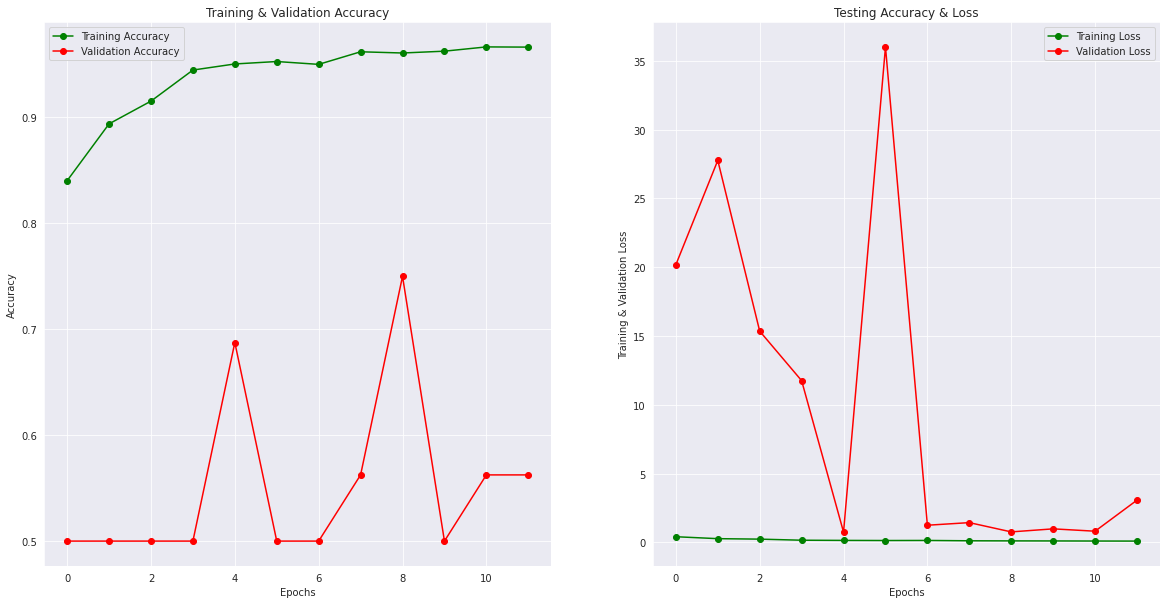

In [16]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [17]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [18]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.79      0.99      0.88       390
   Normal (Class 1)       0.97      0.57      0.72       234

           accuracy                           0.83       624
          macro avg       0.88      0.78      0.80       624
       weighted avg       0.86      0.83      0.82       624



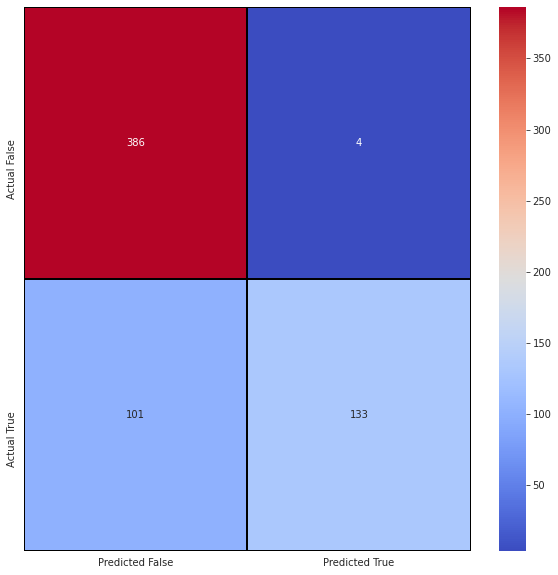

In [19]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['Actual False','Actual True'] , columns = ['Predicted False','Predicted True'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "coolwarm", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')